In [8]:
# Import modules
import pandas as pd
import numpy as np
import sqlite3
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype

In [9]:
# Connect to Database
con = sqlite3.connect('database.db')  # Connect to the new database
csr = con.cursor()  # Set the cursor to the database

In [10]:
sql_query = r"""SELECT V.EncounterID, V.SubjectID, Age_at_Admission AS Age, R.Description AS Race, 
                ET.Description AS Ethnicity, G.Description AS Sex, SOFA AS InitialSOFA, 
                Length_of_Stay_Days AS StayLength, CCS_raw, CCS_age, CCS_Colorado, ECI_raw, Life_Exp as LE, Cho_Adj_Life_Exp As Cho_LE, 
                COVID_Status, Discharge_Status, Intubation, LAC.Description AS NY_Score, Bhavani_Score, Colorado_Score
                    FROM Vent AS V
                    INNER JOIN Encounters E ON E.EncounterID=V.EncounterID
                    INNER JOIN Subjects S ON S.SubjectID=V.SubjectID
                    INNER JOIN Lkp_Race R ON Race=R.ID
                    INNER JOIN Lkp_Ethnicity ET ON Ethnicity=ET.ID
                    INNER JOIN Lkp_Sex G ON Sex=G.ID
                    INNER JOIN Lkp_Priority LAC ON NY_Score=LAC.ID
                        WHERE Timepoint=0 AND Intubation=1;
                    
                    """
                    #LI.Description AS Insurance,
                    #INNER JOIN Lkp_Insurance LI ON Insurance_CD=LI.ID
                    #INNER JOIN Insurance I ON I.EncounterID=V.EncounterID
#Note will need to update to Cho_LE once database_creation updated

#Target is 3707 Encounters (3512 Unique Subjects)
df_database = (pd.read_sql_query(sql_query, con)
    #.drop_duplicates(subset=['EncounterID'], keep='first') #drops intubations >1 for same encounter 
    )

print('Number of Unique Encounters: ', df_database['EncounterID'].drop_duplicates().count())
print('Number of Unique Subjects: ', df_database['SubjectID'].drop_duplicates().count())
print(df_database.info())

Number of Unique Encounters:  3707
Number of Unique Subjects:  3512
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3707 entries, 0 to 3706
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   EncounterID       3707 non-null   object 
 1   SubjectID         3707 non-null   object 
 2   Age               3707 non-null   object 
 3   Race              3707 non-null   object 
 4   Ethnicity         3707 non-null   object 
 5   Sex               3707 non-null   object 
 6   InitialSOFA       3707 non-null   int64  
 7   StayLength        3707 non-null   float64
 8   CCS_raw           3707 non-null   int64  
 9   CCS_age           3707 non-null   int64  
 10  CCS_Colorado      3707 non-null   int64  
 11  ECI_raw           3707 non-null   int64  
 12  LE                3707 non-null   float64
 13  Cho_LE            3707 non-null   float64
 14  COVID_Status      3707 non-null   int64  
 15  Discharge_Status  370

In [13]:
%run 4a_dictionaries_calculators.ipynb

In [14]:
####
# CREATE Pickle for Included Encounters ###
####
df = (df_database
    .assign(
        Protocol = 'Baseline',
        Race = lambda df_1: df_1
            .apply(dict_race_ethnicity, axis=1) #ensure all Hispanic are given Race 'Hispanic'
            .map(dict_race_small), #apply OMB Race categories to all non-Hispanic
        Survived = lambda df_1: df_1
        #    .where(df_1['Discharge_Status'] == 2, 'Expired', 'Survived')
            .apply(dict_discharge, axis=1)
            .astype(CategoricalDtype(categories=['Expired', 'Survived'])).cat.codes, #express all discharge status as integers
        Age = lambda df_1: df_1['Age']
            .mask(df_1['Age'] == '>90', 90)
            .astype(float),
        NY_Score = lambda df_1: df_1['NY_Score']
            .astype(CategoricalDtype(categories=["Red", "Yellow", "Blue"], ordered=True)).cat.codes,
        COVID_Status = lambda df_1: df_1['COVID_Status']
            .astype(CategoricalDtype(categories={0:'Negative', 1:'Positive'})).cat.codes
    )
    .assign(Age_Group = lambda df_2:
            pd.cut(df_2['Age'],
                [0, 25, 35, 45, 55, 65, 75, 85, 90],
                labels=['<25', '25-34', '35-44', '45-54', '55-64', '65-74', '75-84', '>85']
            ),
            Count = 1
    )
    #.drop(['Discharge_Status'], axis=1)
    .astype({'SubjectID': str, 'EncounterID': str, })
)

print (df.info())

df.to_pickle("encounters.pkl")

###COPY PICKLE TO ELSEWHERE
shutil.copy('encounters.pkl', '../app')
shutil.copy('encounters.pkl', '../Model')
shutil.copy('encounters.pkl', '../Sim')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3707 entries, 0 to 3706
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   EncounterID       3707 non-null   object  
 1   SubjectID         3707 non-null   object  
 2   Age               3707 non-null   float64 
 3   Race              3706 non-null   object  
 4   Ethnicity         3707 non-null   object  
 5   Sex               3707 non-null   object  
 6   InitialSOFA       3707 non-null   int64   
 7   StayLength        3707 non-null   float64 
 8   CCS_raw           3707 non-null   int64   
 9   CCS_age           3707 non-null   int64   
 10  CCS_Colorado      3707 non-null   int64   
 11  ECI_raw           3707 non-null   int64   
 12  LE                3707 non-null   float64 
 13  Cho_LE            3707 non-null   float64 
 14  COVID_Status      3707 non-null   int8    
 15  Discharge_Status  3707 non-null   int64   
 16  Intubation        3707 n

'../Sim'

In [7]:
#####
# Create pickle of excluded encounters in same format as included
#####

#Import Exluded Encounters from Pickle
df_excluded_pickle = pd.read_pickle("excluded_raw.pkl")

#Apply cleaning to excluded raw pickle, to align with included encounters pickle
excluded = (df_excluded_pickle
    .assign(
        Protocol = 'Baseline',
        Ethnicity = lambda df_1: df_1['Ethnicity'].map(ethnicity_dict_reverse_lkp), #map strings back from Lookup Table
        Sex = lambda df_1: df_1['Sex'].map(sex_dict_reverse_lkp) #map strings back from Lookup Table
    )
    .assign(
        Race = lambda df_1: df_1
            .apply(dict_race_ethnicity, axis=1) #ensure all Hispanic are given Race 'Hispanic'
            .map(dict_race_small), #apply OMB Race categories to all non-Hispanic
        Survived = lambda df_1: df_1
        #    .where(df_1['Discharge_Status'] == 2, 'Expired', 'Survived')
            .apply(dict_discharge, axis=1)
            .astype(CategoricalDtype(categories=['Expired', 'Survived'])).cat.codes, #express all discharge status as integers
        Age = lambda df_1: df_1['Age']
            .mask(df_1['Age'] == '>90', 90)
            .astype(float),
        #NY_Score = lambda df_1: df_1['NY_Score']
        #    .astype(CategoricalDtype(categories=["Red", "Yellow", "Blue"], ordered=True)).cat.codes,
        COVID_Status = lambda df_1: df_1['COVID_Status'].astype(CategoricalDtype(categories={0:'Negative', 1:'Positive'})).cat.codes,
        #Sex = lambda df_1: df_1['Sex'].astype(CategoricalDtype(categories={1:'Male', 2:'Female'})).cat.codes,
        #Ethnicity = lambda df_1: df_1['Sex'].astype(CategoricalDtype(categories={1:'Hispanic', 2:'Not Hispanic'})).cat.codes,
    )
    .assign(Age_Group = lambda df_2:
            pd.cut(df_2['Age'],
                [0, 25, 35, 45, 55, 65, 75, 85, 90],
                labels=['<25', '25-34', '35-44', '45-54', '55-64', '65-74', '75-84', '>85']
            ),
            Count = 1
    )
    .drop(['Discharge_Status'], axis=1)
    .astype({'SubjectID': str, 'EncounterID': str})
)
excluded.to_pickle("excluded_processed.pkl")

### Quick Survival Graphs by Race, Age, COVID Status

          count   sum      mean
Race                           
>1 Race      16    12  0.750000
AAPI         50    39  0.780000
AIAN          3     3  1.000000
Black       577   438  0.759099
Hispanic    152   124  0.815789
Unknown     157   105  0.668790
White      2752  1969  0.715480


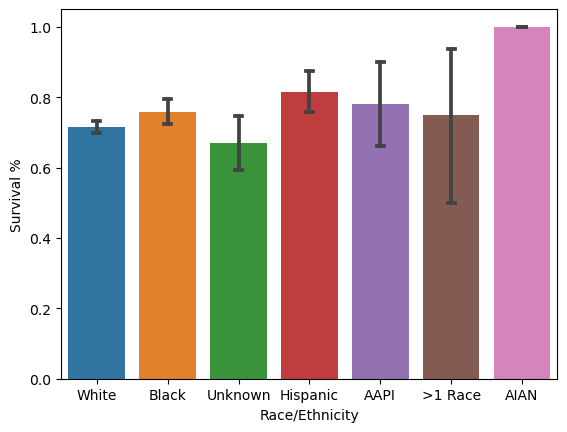

In [8]:
fig1 = plt.figure()
g1 = sns.barplot(y='Survived',
            x='Race',
            data=df,
            capsize = 0.1,
)
g1 = (g1.set (xlabel = "Race/Ethnicity", ylabel = "Survival %")
)
plt.show

#Race Stats
print(df.groupby('Race')['Survived'].agg(['count', 'sum', 'mean']))


          count      mean
Race                     
>1 Race      16  0.750000
AAPI         50  0.780000
AIAN          3  1.000000
Black       577  0.759099
Hispanic    152  0.815789
Unknown     157  0.668790
White      2752  0.715480


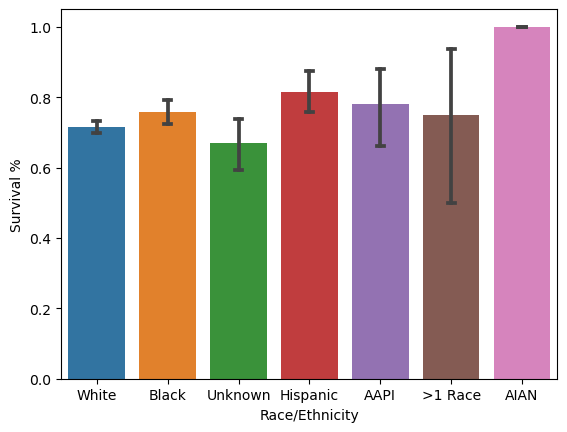

In [9]:
fig2 = plt.figure()
g2 = sns.barplot(y='Survived',
            x='Age_Group',
            data=df,
            capsize = 0.1,
)
g2 = (g2.set (xlabel = "Age_Group", ylabel = "Survival %")
)
plt.show

#Race Stats
print(df.groupby('Age_Group')['Survived'].agg(['count', 'mean']))

          count      mean
Race                     
>1 Race      16  0.750000
AAPI         50  0.780000
AIAN          3  1.000000
Black       577  0.759099
Hispanic    152  0.815789
Unknown     157  0.668790
White      2752  0.715480


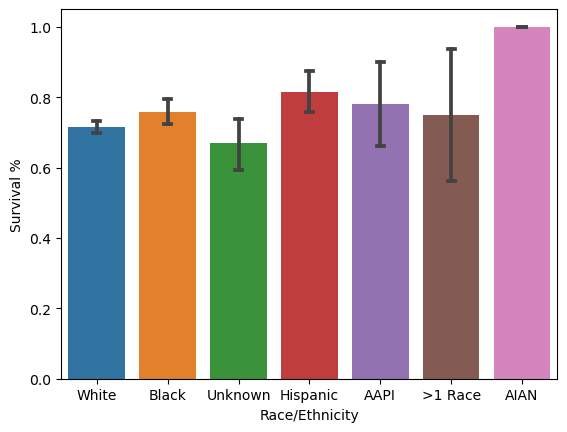

In [10]:
fig3 = plt.figure()
g3 = sns.barplot(y='Survived',
            x='COVID_Status',
            data=df,
            capsize = 0.1,
)
g3 = (g3.set (xlabel = "COVID_Status", ylabel = "Survival %")
)
plt.show

#Race Stats
print(df.groupby('COVID_Status')['Survived'].agg(['count', 'mean']))